## Climate Change Belief Analysis
#### By Nkosisithandile Mkhwanazi

This predict is structured as follows:

    1. Import the libraries and loading of data.
    2. Data pre-processing.
    3. Building all the models.
    4. Choosing the best performing model.
    5. Making the submission.

#### 1. Import all the libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import re


from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Loading the datasets

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.head(10)

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954
5,1,Worth a read whether you do or don't believe i...,425577
6,1,RT @thenation: Mike Pence doesn’t believe in g...,294933
7,1,RT @makeandmendlife: Six big things we can ALL...,992717
8,1,@AceofSpadesHQ My 8yo nephew is inconsolable. ...,664510
9,1,RT @paigetweedy: no offense… but like… how do ...,260471


In [4]:
test_df.head(10)

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928
5,RT @nycjim: Trump muzzles employees of several...,75639
6,@bmastenbrook yes wrote that in 3rd yr Comp Sc...,211536
7,RT @climatehawk1: Indonesian farmers weather #...,569434
8,RT @guardian: British scientists face a ‘huge ...,315368
9,Aid For Agriculture | Sustainable agriculture ...,591733


In [5]:
# Data exploration:

train_df.shape

(15819, 3)

In [6]:
test_df.shape

(10546, 2)

In [7]:
sentiment_labels = list(train_df.sentiment.unique())
print(sentiment_labels)

[1, 2, 0, -1]


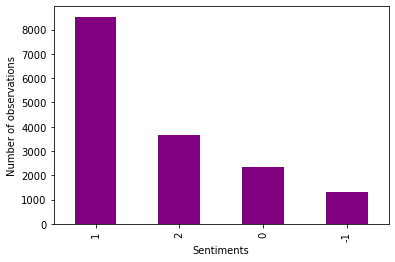

In [8]:
train_df['sentiment'].value_counts().plot(kind = 'bar', color='purple')
plt.xlabel('Sentiments')
plt.ylabel('Number of observations')
plt.show()

#### 2. Data Pre-processing

In [9]:
# Remove punctuation from messages:

def remove_punctuation(message):
    punc = string.punctuation + 'RT' + '0123456789'
    return ''.join([m for m in message if m not in punc])

In [10]:
train_df['message'] = train_df['message'].apply(remove_punctuation)
test_df['message'] = test_df['message'].apply(remove_punctuation)

In [11]:
# Convert to lowercase:

train_df['message'] = train_df['message'].str.lower()
test_df['message'] = test_df['message'].str.lower()

In [12]:
# Remove any url:

pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'

train_df['message'] = train_df['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)
test_df['message'] = test_df['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

In [13]:
w_tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

In [14]:
train_df['message'] = train_df['message'].apply(lemmatize_words)
test_df['message'] = test_df['message'].apply(lemmatize_words)

In [15]:
train_df.head(10)

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,it not like we lack evidence of anthropogenic ...,126103
2,2,awstory esearchers say we have three year to a...,698562
3,1,odayinmaker wied wa a pivotal year in the war ...,573736
4,1,soynoviodeodas it and a racist sexist climate ...,466954
5,1,worth a read whether you do or dont believe in...,425577
6,1,thenation mike penny doesn’t believe in global...,294933
7,1,makeandmendlife six big thing we can all do to...,992717
8,1,aceofspadeshq my yo nephew is inconsolable he ...,664510
9,1,paigetweedy no offense… but like… how do you j...,260471


In [16]:
test_df.head(10)

,message,tweetid
0,europe will now be looking to china to make su...,169760
1,combine this with the polling of staffer re cl...,35326
2,he scary unimpeachable evidence that climate c...,224985
3,karoli morgfair osborneink dailykos putin got ...,476263
4,fakewillmoore female orgasm cause global warmi...,872928
5,nycjim rump muzzle employee of several gov’t a...,75639
6,bmastenbrook yes wrote that in rd yr comp sci ...,211536
7,climatehawk indonesian farmer weather climate ...,569434
8,guardian british scientist face a ‘huge hit’ i...,315368
9,aid for agriculture sustainable agriculture an...,591733


#### 3. Building the models

In [17]:
X = train_df['message']
y = train_df['sentiment']

In [18]:
vectorizer = TfidfVectorizer(stop_words='english', min_df=0.001, ngram_range=(1,2))
X_vect = vectorizer.fit_transform(X)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_vect, 
                                                    y,
                                                   test_size=0.1)
                                                   

In [20]:
names = ['Logistic Regression', 'Random Forest', 'Decison Tree',
        'Nearest Neighbours', 'Linear SVM', 'Naive-Bayes']

In [21]:
classifiers = [
    LogisticRegression(),
    RandomForestClassifier(n_estimators=100, random_state=42),
    DecisionTreeClassifier(),
    KNeighborsClassifier(),
    LinearSVC(),
    MultinomialNB()
]

In [22]:
results = []

models = {}
confusion = {}
class_report = {}


for name, clf in zip(names, classifiers):    
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train, y_train)
    
    print ('... predicting')
    y_pred = clf.predict(X_train)   
    y_pred_test = clf.predict(X_test)
    
    print ('... scoring')
    
    f1        = metrics.f1_score(y_train, y_pred, average='macro')    
    f1_test   = metrics.f1_score(y_test, y_pred_test, average='macro')    
    
    # Save the results to dictionaries
    models[name] = clf    
    confusion[name] = metrics.confusion_matrix(y_train, y_pred)
    class_report[name] = metrics.classification_report(y_train, y_pred)
    
    results.append([name, f1, f1_test, run_time.best])

    
results = pd.DataFrame(results, columns=['Classifier', 'F1 Train', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)

Fitting Logistic Regression model...
... predicting
... scoring
Fitting Random Forest model...
... predicting
... scoring
Fitting Decison Tree model...
... predicting
... scoring
Fitting Nearest Neighbours model...
... predicting
... scoring
Fitting Linear SVM model...
... predicting
... scoring
Fitting Naive-Bayes model...
... predicting
... scoring


In [23]:
results.sort_values('F1 Test', ascending=False)

,F1 Train,F1 Test,Train Time
Classifier,,,
Linear SVM,0.727533,0.602876,6.811347
Logistic Regression,0.677148,0.591755,6.276609
Random Forest,0.981675,0.557828,56.166512
Nearest Neighbours,0.667498,0.523453,0.070191
Naive-Bayes,0.607022,0.522405,0.027995
Decison Tree,0.981724,0.504917,15.120739


#### 4. Choosing best performing model

In [24]:
model = LogisticRegression()
model.fit(X_train, y_train)
model_pred = model.predict(X_test)
f1 = metrics.f1_score(y_test, model_pred, average='macro')
f1

0.5917546302376727

#### 5. Making the submission

In [25]:
X_test_ = test_df['message']
test_vectorized = vectorizer.transform(X_test_)

In [26]:
model_test_pred = model.predict(test_vectorized)

In [27]:
test_df['sentiment'] = model_test_pred
test_df[['tweetid','sentiment']].to_csv('Submission.csv', index=0)